In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set random seed
SEED = 100
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
# Google Colab
# DATA_PATH = "/content/datafiles"
# SAVE_PATH = "/content/models"

DATA_PATH = "/Users/trevoryu/Code/data/mnist"
SAVE_PATH = "/Users/trevoryu/Code/models/wat-ai"

# Obtain dataset

In [4]:
(train_dataset, val_dataset, test_dataset), ds_info = tfds.load(
    "mnist",
    split=["train[0:50_000]", "train[-10_000:]", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir=DATA_PATH
)
list(map(len, [train_dataset, val_dataset, test_dataset]))

[50000, 10000, 10000]

In [5]:
x_plot, y_plot = tfds.load(
    "mnist",
    split="test[1000:1020]",
    shuffle_files=False,
    as_supervised=True,
    data_dir=DATA_PATH,
    batch_size=-1
)
# x_plot dtype is int8, scale between [0, 1] in float32 dtype
x_plot = x_plot / 255

In [6]:
x_plot.shape

TensorShape([20, 28, 28, 1])

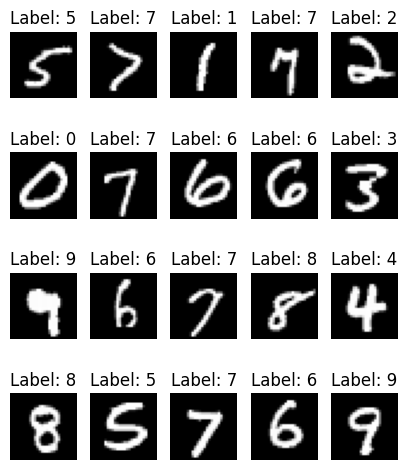

Each image is a tf.Tensor and has shape (28, 28, 1).
The labels are the integers 0 to 9, representing the digits.


In [7]:
fig, axs = plt.subplots(4, 5, figsize=(5, 6))

plot_images = []
plot_labels = []

for ax, image, label in zip(axs.flatten(), x_plot, y_plot):
    # image = x_plot[i]
    # label = y_plot[i]

    # Save this data for later
    plot_images.append(tf.expand_dims(image, 0))
    plot_labels.append(label)

    # Plot each image
    ax.imshow(tf.squeeze(image), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

plot_images = tf.concat(plot_images, axis=0)  # Combine all the images into a single batch for later

print(f"Each image is a tf.Tensor and has shape {image.shape}.")
print(f"The labels are the integers 0 to 9, representing the digits.")

# Convert data into tensors

In [8]:
def preprocess(x, y):
    """
    Preprocess input data to neural network
    :param x: tf.Tensor image batch, of shape (B, 28, 28, 1)
    :param y: tf.Tensor labels, of shape (B,)

    :returns: (x, y), processed inputs of shapes ((B, 784), (B,))
    """
    # # Reshaping the data
    # x = tf.reshape(x, shape=[-1, 784])
    # Rescaling the data
    x = x / 255
    return x, y

In [9]:
BATCH_SIZE = 128

train_dataset = train_dataset.map(preprocess)
train_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Define model architecture

In [10]:
model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10)
])

model.compile()

In [11]:
y_pred = model(x_plot)
y_pred.shape

TensorShape([20, 10])

# Select hyperparameters

In [12]:
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 1e-3

AUTOTUNE = tf.data.AUTOTUNE

In [13]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

train_dataset = train_dataset.cache().shuffle(len(train_dataset)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [14]:
loss_function(y_plot, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2811742>

In [15]:
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

In [16]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/20
79/79 [==============================] - 2s 21ms/step - loss: 0.4458 - sparse_categorical_accuracy: 0.8652 - val_loss: 20.3167 - val_sparse_categorical_accuracy: 0.9580
Epoch 2/20
79/79 [==============================] - 1s 18ms/step - loss: 0.1541 - sparse_categorical_accuracy: 0.9556 - val_loss: 9.5006 - val_sparse_categorical_accuracy: 0.9743
Epoch 3/20
79/79 [==============================] - 1s 17ms/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9723 - val_loss: 7.6744 - val_sparse_categorical_accuracy: 0.9792
Epoch 4/20
79/79 [==============================] - 1s 17ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9798 - val_loss: 6.6660 - val_sparse_categorical_accuracy: 0.9852
Epoch 5/20
79/79 [==============================] - 1s 18ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9825 - val_loss: 2.8763 - val_sparse_categorical_accuracy: 0.9912
Epoch 6/20
79/79 [==============================] - 1s 19ms/step - loss: 0.0206 - sparse_categorical_acc

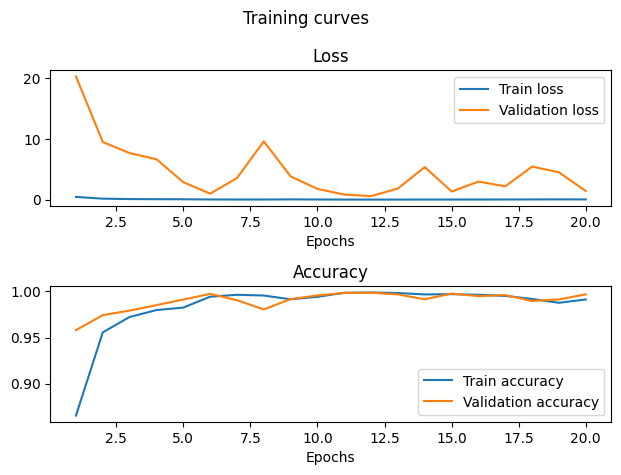

In [17]:
fig, axs = plt.subplots(2, 1)

labels = {
    "loss": "Train loss",
    "sparse_categorical_accuracy": "Train accuracy",
    "val_loss": "Validation loss",
    "val_sparse_categorical_accuracy": "Validation accuracy"
}

epochs = np.arange(EPOCHS) + 1

for key, metric in history.history.items():
    if "loss" in key:
        epochs = np.arange(len(metric)) + 1
        axs[0].plot(epochs, metric, label=labels[key])
    else:
        axs[1].plot(epochs, metric, label=labels[key])

for ax in axs:
    ax.legend()
    ax.set_xlabel("Epochs")

axs[0].set_title("Loss")
# axs[0].set_ylim(-0.05, 0.5)
axs[1].set_title("Accuracy")
plt.suptitle("Training curves")
plt.tight_layout()
plt.show()

# Evaluate on the test set

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

79/79 [==============================] - 1s 5ms/step - loss: 0.1617 - sparse_categorical_accuracy: 0.9626
Test loss: 0.162
Test accuracy: 96.26%


In [19]:
y_pred = model.predict(x_plot)
y_pred = y_pred.argmax(axis=-1)

1/1 [==============================] - 0s 42ms/step


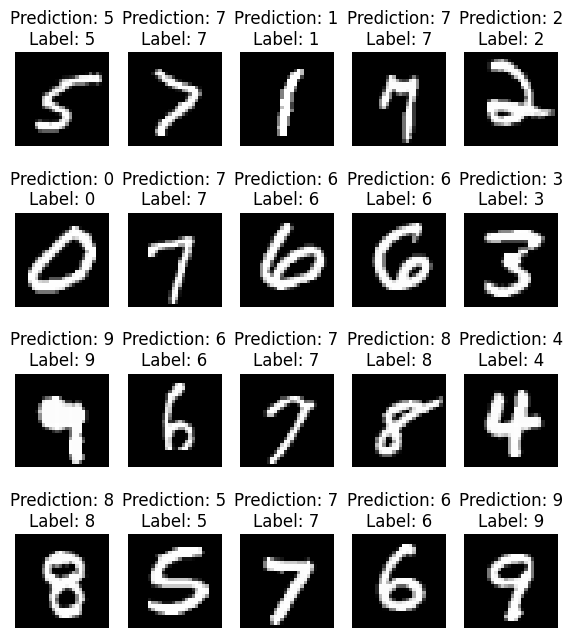

In [20]:
# Plot and show the labels
fig, axs = plt.subplots(4, 5, figsize=(7, 8))

for ax, image, label, pred in zip(axs.flatten(), x_plot, y_plot, y_pred):
    # Plot each image
    ax.imshow(tf.squeeze(image), cmap="gray")
    ax.set_title(f"Prediction: {pred}\nLabel: {label}")
    ax.axis("off")
plt.show()

# How to stop the model from overfitting?

In the Dive into Deep Learning session, we'll talk more about "regularization," which are techniques to stop from overfitting. But one easy one to use in Tensorflow is early stopping. Early stopping allows us to try to stop training before we get to overfitting. We can save a version of the model's parameters and use that in testing.

In [21]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=3),
    tf.keras.callbacks.ModelCheckpoint(SAVE_PATH, monitor="val_sparse_categorical_accuracy", save_best_only=True)
]

In [22]:
model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

In [23]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
77/79 [============================>.] - ETA: 0s - loss: 0.4485 - sparse_categorical_accuracy: 0.9152INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


79/79 [==============================] - 2s 26ms/step - loss: 0.4443 - sparse_categorical_accuracy: 0.9154 - val_loss: 20.6526 - val_sparse_categorical_accuracy: 0.9517
Epoch 2/20
76/79 [===========================>..] - ETA: 0s - loss: 0.1533 - sparse_categorical_accuracy: 0.9538INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.1523 - sparse_categorical_accuracy: 0.9544 - val_loss: 10.6931 - val_sparse_categorical_accuracy: 0.9715
Epoch 3/20
76/79 [===========================>..] - ETA: 0s - loss: 0.0915 - sparse_categorical_accuracy: 0.9725INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


79/79 [==============================] - 2s 26ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0.9723 - val_loss: 5.0100 - val_sparse_categorical_accuracy: 0.9843
Epoch 4/20
79/79 [==============================] - 1s 18ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9837 - val_loss: 5.2563 - val_sparse_categorical_accuracy: 0.9822
Epoch 5/20
79/79 [==============================] - ETA: 0s - loss: 0.0376 - sparse_categorical_accuracy: 0.9887INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.0376 - sparse_categorical_accuracy: 0.9887 - val_loss: 5.8028 - val_sparse_categorical_accuracy: 0.9876
Epoch 6/20
77/79 [============================>.] - ETA: 0s - loss: 0.0353 - sparse_categorical_accuracy: 0.9884INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.0351 - sparse_categorical_accuracy: 0.9885 - val_loss: 2.7469 - val_sparse_categorical_accuracy: 0.9921
Epoch 7/20
77/79 [============================>.] - ETA: 0s - loss: 0.0195 - sparse_categorical_accuracy: 0.9938INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.7750 - val_sparse_categorical_accuracy: 0.9974
Epoch 8/20
77/79 [============================>.] - ETA: 0s - loss: 0.0191 - sparse_categorical_accuracy: 0.9941INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.5696 - val_sparse_categorical_accuracy: 0.9989
Epoch 9/20
79/79 [==============================] - 2s 22ms/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9961 - val_loss: 2.2671 - val_sparse_categorical_accuracy: 0.9945
Epoch 10/20
79/79 [==============================] - 2s 19ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9917 - val_loss: 4.8229 - val_sparse_categorical_accuracy: 0.9861
Epoch 11/20
79/79 [==============================] - 1s 18ms/step - loss: 0.0183 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.3444 - val_sparse_categorical_accuracy: 0.9984


Best val accuracy: 99.890%


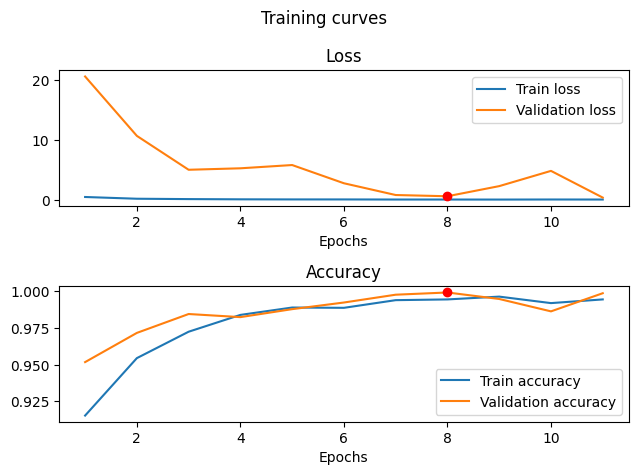

In [24]:
fig, axs = plt.subplots(2, 1)

labels = {
    "loss": "Train loss",
    "sparse_categorical_accuracy": "Train accuracy",
    "val_loss": "Validation loss",
    "val_sparse_categorical_accuracy": "Validation accuracy"
}

epochs = np.arange(EPOCHS) + 1
best_ind = np.argmax(history.history["val_sparse_categorical_accuracy"])
best_acc = history.history["val_sparse_categorical_accuracy"][best_ind]
best_loss = history.history["val_loss"][best_ind]

for key, metric in history.history.items():
    if "loss" in key:
        epochs = np.arange(len(metric)) + 1
        axs[0].plot(epochs, metric, label=labels[key])
    else:
        axs[1].plot(epochs, metric, label=labels[key])

axs[0].plot(epochs[best_ind], best_loss, "ro")
axs[1].plot(epochs[best_ind], best_acc, "ro")

for ax in axs:
    ax.legend()
    ax.set_xlabel("Epochs")


axs[0].set_title("Loss")
# axs[0].set_ylim(-0.05, 0.5)
axs[1].set_title("Accuracy")
plt.suptitle("Training curves")
plt.tight_layout()

print(f"Best val accuracy: {best_acc*100:.3f}%")
plt.show()

In [25]:
# Evaluate on test set with best model
best_model = tf.keras.models.load_model(SAVE_PATH)
checkpoint_test_loss, checkpoint_test_accuracy = best_model.evaluate(test_dataset)

print(f"Test loss, best model: {checkpoint_test_loss:.3f}")
print(f"Test accuracy, best model: {checkpoint_test_accuracy*100:.2f}%")

print(f"Test loss, old model: {test_loss:.3f}")
print(f"Test accuracy, old model: {test_accuracy*100:.2f}%")

79/79 [==============================] - 0s 5ms/step - loss: 0.1440 - sparse_categorical_accuracy: 0.9638
Test loss, best model: 0.144
Test accuracy, best model: 96.38%
Test loss, old model: 0.162
Test accuracy, old model: 96.26%
